In [1]:
from rdkit import Chem
from rdkit.Chem import MACCSkeys, Draw
import pandas as pd
import numpy as np
import json
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns

# Charger les SMILES depuis le fichier
with open("ligands.txt", "r") as f:
    smiles_list = [line.strip() for line in f if line.strip()]

# Charger le dictionnaire des scores de docking
with open("ligand_dict.txt", "r") as f:
    score_dict = json.load(f)

# Convertir les SMILES en Mol et associer les scores
mols = []
valid_smiles = []
scores = []

for smi in smiles_list:
    mol = Chem.MolFromSmiles(smi)
    if mol is not None:
        mols.append(mol)
        valid_smiles.append(smi)
        scores.append(score_dict.get(smi, None))  # None si absent


/home/maillasson-m/miniforge3/envs/smiles_cluster_hotspots/lib/python3.10/site-packages/numpy/_core/getlimits.py:551: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


In [2]:
# G√©n√©rer les MACCS fingerprints
fps = [MACCSkeys.GenMACCSKeys(mol) for mol in mols]
fps_array = np.array([fp.ToList() for fp in fps])

# R√©duction de dimension par PCA
pca = PCA(n_components=2)
fps_pca = pca.fit_transform(fps_array)

# Clustering hi√©rarchique
clusterer = AgglomerativeClustering(n_clusters=5)
labels = clusterer.fit_predict(fps_array)

# Cr√©er un dataframe
df = pd.DataFrame(fps_pca, columns=["PC1", "PC2"])
df["SMILES"] = valid_smiles
df["Cluster"] = labels.astype(str)
df["Score"] = scores


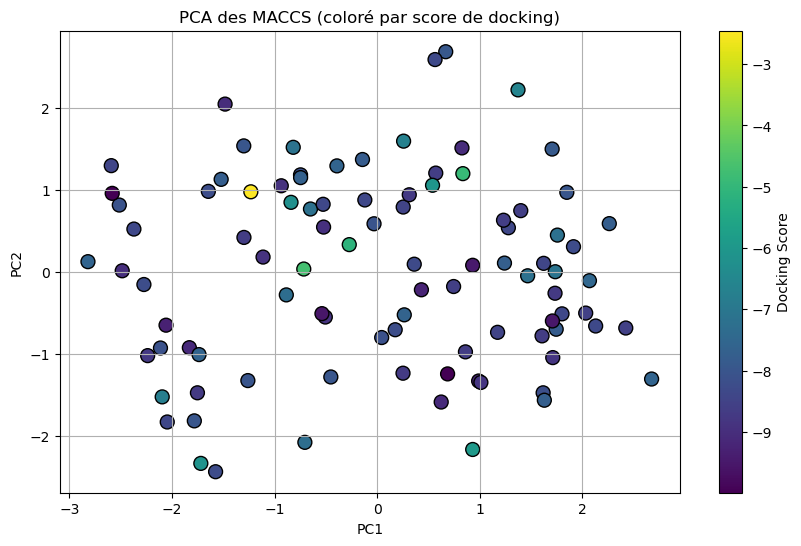

<Figure size 640x480 with 0 Axes>

In [3]:
# Affichage PCA avec scores en couleurs
plt.figure(figsize=(10, 6))
sc = plt.scatter(df["PC1"], df["PC2"], c=df["Score"], cmap="viridis", s=100, edgecolor='k')
plt.title("PCA des MACCS (color√© par score de docking)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(sc, label="Docking Score")
plt.grid(True)
plt.show()
plt.savefig("pca_colored_by_score.png", dpi=300)

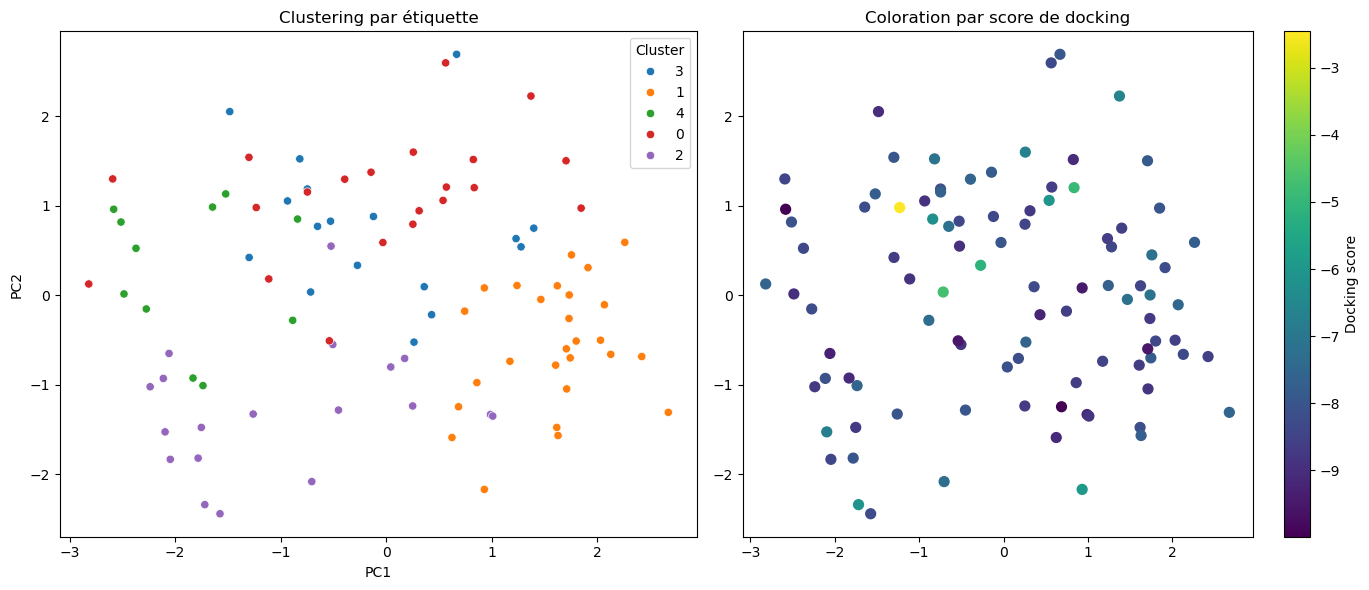

In [4]:
# Configuration pour un affichage c√¥te √† c√¥te
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Graphe 1 : Coloration par cluster
sns.scatterplot(data=df, x='PC1', y='PC2', hue='Cluster', palette='tab10', ax=axes[0])
axes[0].set_title("Clustering par √©tiquette")

# Graphe 2 : Coloration par score de docking
sc = axes[1].scatter(df['PC1'], df['PC2'], c=df['Score'], cmap='viridis', s=50)
axes[1].set_title("Coloration par score de docking")
plt.colorbar(sc, ax=axes[1], label='Docking score')

plt.tight_layout()
plt.show()
fig.savefig("pca_clusters_scores.png", dpi=300)
df.to_csv("clustering_results.csv", index=False)


In [5]:
# Sauvegarder les clusters avec scores
df.to_csv("clusters_maccs_scores.csv", index=False)
print("Fichier 'clusters_maccs_scores.csv' export√©.")


Fichier 'clusters_maccs_scores.csv' export√©.


In [6]:
from IPython.display import display

n_per_cluster = 3
for clust in sorted(df["Cluster"].unique()):
    sub_df = df[df["Cluster"] == clust].nsmallest(n_per_cluster, "Score")
    mols_to_draw = [Chem.MolFromSmiles(smi) for smi in sub_df["SMILES"]]
    legends = [f"{smi}\nScore: {score:.2f}" for smi, score in zip(sub_df["SMILES"], sub_df["Score"])]
    print(f"Cluster {clust} - Meilleurs scores :")
    #g√©n√©rer l'image
    img = Draw.MolsToGridImage(mols_to_draw, molsPerRow=3, subImgSize=(200, 200), legends=legends)

    #sauvegarder image
    img.save(f"clsuter_top_mol.png")

    #afficher dans notebook
    display(img)


Cluster 0 - Meilleurs scores :


AttributeError: 'Image' object has no attribute 'save'

Cluster 0 - Meilleurs scores :


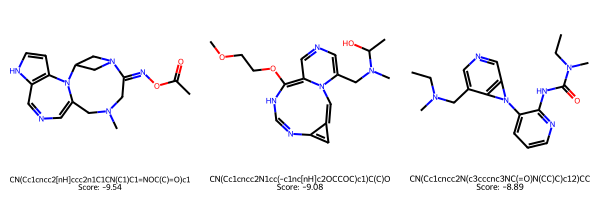

Cluster 1 - Meilleurs scores :


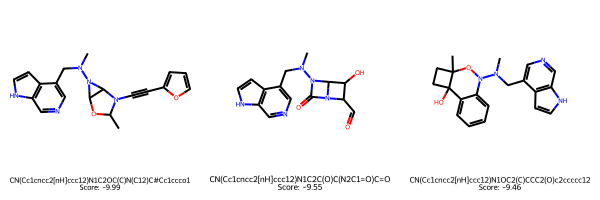

Cluster 2 - Meilleurs scores :


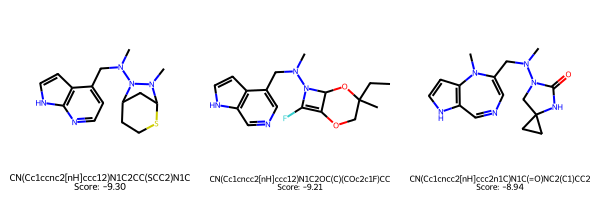

Cluster 3 - Meilleurs scores :


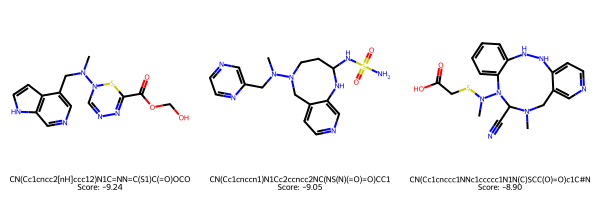

Cluster 4 - Meilleurs scores :


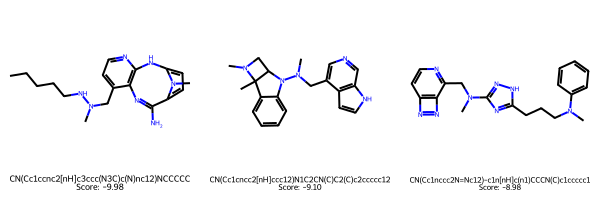

In [10]:
from rdkit.Chem import Draw
from rdkit import Chem
from IPython.display import display
from PIL import Image
import io

n_per_cluster = 3
for clust in sorted(df["Cluster"].unique()):
    sub_df = df[df["Cluster"] == clust].nsmallest(n_per_cluster, "Score")
    mols_to_draw = [Chem.MolFromSmiles(smi) for smi in sub_df["SMILES"]]
    legends = [f"{smi}\nScore: {score:.2f}" for smi, score in zip(sub_df["SMILES"], sub_df["Score"])]
    
    print(f"Cluster {clust} - Meilleurs scores :")

    # G√©n√©rer une image PIL (vraie) via l'argument returnPNG=False
    pil_img = Draw.MolsToGridImage(
        mols_to_draw,
        molsPerRow=3,
        subImgSize=(200, 200),
        legends=legends,
        useSVG=False,
        returnPNG=False  # << C'est √ßa qui force le retour PIL
    )

    # Sauvegarder l‚Äôimage PNG
    pil_img.save(f"cluster_{clust}_top_molecules.png")

    # Afficher dans le notebook
    display(pil_img)


/tmp/ipykernel_64/82082558.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Cluster", y="Score", palette="Set3")


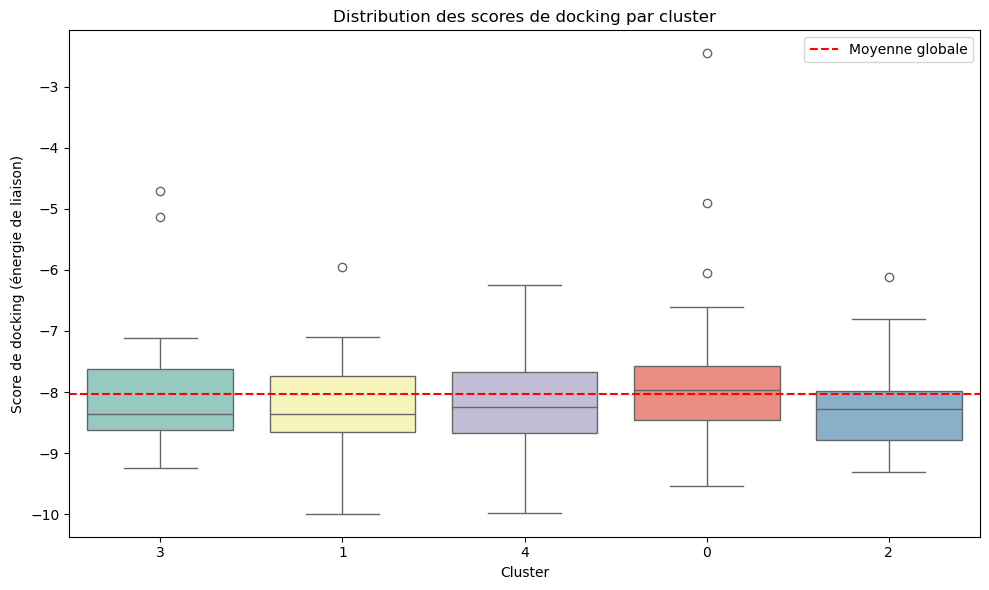

<Figure size 640x480 with 0 Axes>

In [11]:
# Assurer que les scores sont bien convertis en float (au cas o√π il y aurait des None)
df = df[df["Score"].notna()]
df["Score"] = df["Score"].astype(float)

# Visualiser la distribution des scores par cluster
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x="Cluster", y="Score", palette="Set3")
plt.title("Distribution des scores de docking par cluster")
plt.ylabel("Score de docking (√©nergie de liaison)")
plt.xlabel("Cluster")
plt.axhline(df["Score"].mean(), color="red", linestyle="--", label="Moyenne globale")
plt.legend()
plt.tight_layout()
plt.show()
plt.savefig("distributions_by_cluster.png", dpi=300)

In [12]:
# Classement des clusters par score moyen
cluster_stats = df.groupby("Cluster")["Score"].agg(["mean", "median", "std", "min", "max", "count"]).sort_values("mean")
print("R√©sum√© statistique par cluster :\n")
print(cluster_stats)


R√©sum√© statistique par cluster :

             mean  median       std    min    max  count
Cluster                                                 
2       -8.239842  -8.271  0.805889 -9.301 -6.116     19
1       -8.232778  -8.351  0.852364 -9.991 -5.951     27
4       -8.171273  -8.247  0.988661 -9.984 -6.252     11
3       -7.902588  -8.357  1.264080 -9.242 -4.717     17
0       -7.586571  -7.965  1.587193 -9.539 -2.456     21


## üîç Partie 1 ‚Äî Identification des motifs fr√©quents dans un cluster

In [13]:
# from rdkit import Chem
from rdkit.Chem import AllChem, Draw, rdMolDescriptors
from collections import Counter, defaultdict
from tqdm.notebook import tqdm  # Barre de progression pour Jupyter
import pandas as pd

def extract_frequent_motifs(smiles_list, top_k=20, radius=2, nBits=2048):
    mols = [Chem.MolFromSmiles(sm) for sm in smiles_list if Chem.MolFromSmiles(sm)]
    bit_counts = Counter()
    bit_info_all = defaultdict(list)

    # Analyse des empreintes
    for mol in tqdm(mols, desc="Calcul des empreintes"):
        bit_info = {}
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits, bitInfo=bit_info)
        for bit, info in bit_info.items():
            bit_counts[bit] += 1
            bit_info_all[bit].append((mol, info))  # info = liste de (atom_idx, radius)

    top_bits = bit_counts.most_common(top_k)
    images = []
    smiles_motifs = []
    stats = []

    # Extraction et dessin des sous-structures
    for bit, count in tqdm(top_bits, desc="Extraction des motifs"):
        found = False
        for mol, info_list in bit_info_all[bit]:
            for atom_idx, rad in info_list:
                try:
                    env = Chem.FindAtomEnvironmentOfRadiusN(mol, rad, atom_idx)
                    amap = {}
                    submol = Chem.PathToSubmol(mol, env, atomMap=amap)
                    smiles = Chem.MolToSmiles(submol)
                    images.append(submol)
                    smiles_motifs.append(smiles)
                    stats.append({'Bit_ID': bit, 'Occurrences': count, 'Radius': rad, 'Motif_SMILES': smiles})
                    found = True
                    break
                except Exception as e:
                    continue
            if found:
                break

    img = Draw.MolsToGridImage(images, molsPerRow=5, subImgSize=(200, 200), legends=[f"Bit {bit}" for bit, _ in top_bits])
    motifs_df = pd.DataFrame(stats)
    return img, motifs_df


# Appel de la fonction
img = extract_frequent_motifs(smiles_list)
img  # L'affichage se fait ici       

Calcul des empreintes:   0%|          | 0/95 [00:00<?, ?it/s]

[16:29:12] DEPRECATION WARNING: please use MorganGenerator
[16:29:12] DEPRECATION WARNING: please use MorganGenerator
[16:29:12] DEPRECATION WARNING: please use MorganGenerator
[16:29:12] DEPRECATION WARNING: please use MorganGenerator
[16:29:12] DEPRECATION WARNING: please use MorganGenerator
[16:29:12] DEPRECATION WARNING: please use MorganGenerator
[16:29:12] DEPRECATION WARNING: please use MorganGenerator
[16:29:12] DEPRECATION WARNING: please use MorganGenerator
[16:29:12] DEPRECATION WARNING: please use MorganGenerator
[16:29:12] DEPRECATION WARNING: please use MorganGenerator
[16:29:12] DEPRECATION WARNING: please use MorganGenerator
[16:29:12] DEPRECATION WARNING: please use MorganGenerator
[16:29:12] DEPRECATION WARNING: please use MorganGenerator
[16:29:12] DEPRECATION WARNING: please use MorganGenerator
[16:29:12] DEPRECATION WARNING: please use MorganGenerator
[16:29:12] DEPRECATION WARNING: please use MorganGenerator
[16:29:12] DEPRECATION WARNING: please use MorganGenerat

Extraction des motifs:   0%|          | 0/20 [00:00<?, ?it/s]

(<IPython.core.display.Image object>,
     Bit_ID  Occurrences  Radius Motif_SMILES
 0      378           95       0             
 1     1057           95       0             
 2     1380           95       0             
 3     1873           95       0             
 4     1750           93       1          ccc
 5       80           90       0             
 6      881           87       0             
 7      935           86       0             
 8     1114           86       0             
 9     1163           86       1           CN
 10     507           82       1          cCN
 11     806           74       1       c[nH]c
 12     711           73       2     ccc[nH]c
 13    1506           73       1       cc[nH]
 14    1349           72       1       cc(c)C
 15    1026           64       2  cc(c)cc[nH]
 16    1357           63       1       cc(c)c
 17     235           61       1       CN(C)N
 18    1535           61       1          ccn
 19     674           60       2  cc(c)CN(

Calcul des empreintes:   0%|          | 0/95 [00:00<?, ?it/s]

[16:29:47] DEPRECATION WARNING: please use MorganGenerator
[16:29:47] DEPRECATION WARNING: please use MorganGenerator
[16:29:47] DEPRECATION WARNING: please use MorganGenerator
[16:29:47] DEPRECATION WARNING: please use MorganGenerator
[16:29:47] DEPRECATION WARNING: please use MorganGenerator
[16:29:47] DEPRECATION WARNING: please use MorganGenerator
[16:29:47] DEPRECATION WARNING: please use MorganGenerator
[16:29:47] DEPRECATION WARNING: please use MorganGenerator
[16:29:47] DEPRECATION WARNING: please use MorganGenerator
[16:29:47] DEPRECATION WARNING: please use MorganGenerator
[16:29:47] DEPRECATION WARNING: please use MorganGenerator
[16:29:47] DEPRECATION WARNING: please use MorganGenerator
[16:29:47] DEPRECATION WARNING: please use MorganGenerator
[16:29:47] DEPRECATION WARNING: please use MorganGenerator
[16:29:47] DEPRECATION WARNING: please use MorganGenerator
[16:29:47] DEPRECATION WARNING: please use MorganGenerator
[16:29:47] DEPRECATION WARNING: please use MorganGenerat

Extraction des motifs:   0%|          | 0/20 [00:00<?, ?it/s]

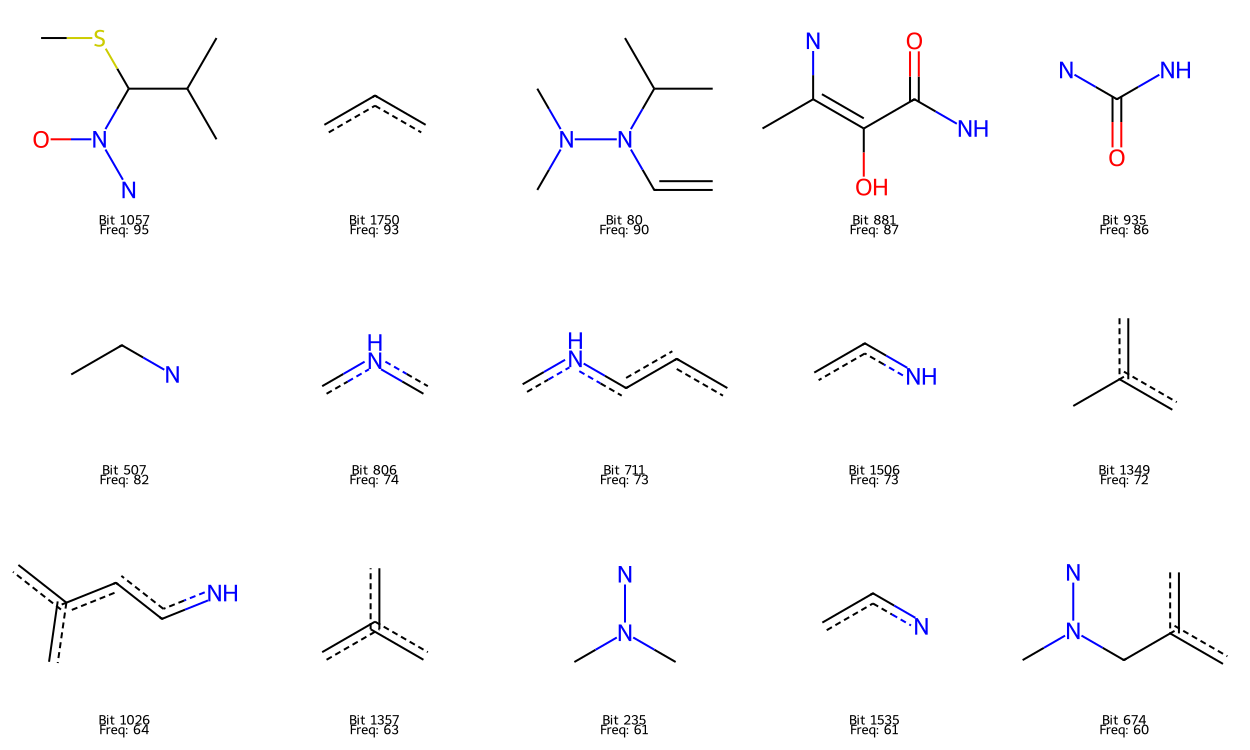

In [15]:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, rdMolDescriptors
from collections import Counter, defaultdict
from tqdm.notebook import tqdm  # Barre de progression pour Jupyter
import pandas as pd

def extract_frequent_motifs(smiles_list, top_k=20, radius=2, nBits=2048):
    mols = [Chem.MolFromSmiles(sm) for sm in smiles_list if Chem.MolFromSmiles(sm)]
    bit_counts = Counter()
    bit_info_all = defaultdict(list)

    # Analyse des empreintes
    for mol in tqdm(mols, desc="Calcul des empreintes"):
        bit_info = {}
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits, bitInfo=bit_info)
        for bit, info in bit_info.items():
            bit_counts[bit] += 1
            bit_info_all[bit].append((mol, info))

    top_bits = bit_counts.most_common(top_k)
    images = []
    smiles_motifs = []
    stats = []
    legends = []

    ignore_smiles = {"", "C", "CC"}  # Motifs trop simples

    # Extraction et annotation des sous-structures
    for bit, count in tqdm(top_bits, desc="Extraction des motifs"):
        found = False
        for mol, info_list in bit_info_all[bit]:
            for atom_idx, rad in info_list:
                try:
                    env = Chem.FindAtomEnvironmentOfRadiusN(mol, rad, atom_idx)
                    amap = {}
                    submol = Chem.PathToSubmol(mol, env, atomMap=amap)

                    if submol.GetNumAtoms() < 3:
                        continue

                    smiles = Chem.MolToSmiles(submol)
                    if smiles in ignore_smiles:
                        continue

                    images.append(submol)
                    smiles_motifs.append(smiles)
                    stats.append({'Bit_ID': bit, 'Occurrences': count, 'Radius': rad, 'Motif_SMILES': smiles})
                    legends.append(f"Bit {bit}\nFreq: {count}")
                    found = True
                    break
                except Exception:
                    continue
            if found:
                break

    img = Draw.MolsToGridImage(images, molsPerRow=5, subImgSize=(250, 250), legends=legends)
    motifs_df = pd.DataFrame(stats)
    return img, motifs_df


# Appel de la fonction
img, motifs_df = extract_frequent_motifs(smiles_list)
img  # Affichage dans Jupyter


## üß¨ Partie 2 ‚Äî D√©tection des hotspots √† partir d‚Äôun fichier de docking PDB

In [ ]:

from Bio.PDB import PDBParser, NeighborSearch, is_aa
from Bio.PDB.Polypeptide import three_to_one

def get_hotspots_from_pdb(pdb_file, cutoff=4.0):
    parser = PDBParser(QUIET=True)
    structure = parser.get_structure("dock", pdb_file)

    protein_atoms = []
    ligand_atoms = []

    for model in structure:
        for chain in model:
            for res in chain:
                het = res.id[0].strip()
                if het == "":  # Prot√©ine
                    if is_aa(res):
                        protein_atoms.extend(res.get_atoms())
                elif het.startswith("H") or res.get_resname() not in ["HOH"]:  # Ligand
                    ligand_atoms.extend(res.get_atoms())

    ns = NeighborSearch(protein_atoms)
    hotspot_residues = set()

    for atom in ligand_atoms:
        neighbors = ns.search(atom.coord, cutoff)
        for neighbor in neighbors:
            res = neighbor.get_parent()
            if is_aa(res):
                chain_id = res.get_parent().id
                try:
                    aa = three_to_one(res.get_resname())
                except KeyError:
                    aa = res.get_resname()
                hotspot_residues.add((chain_id, res.id[1], aa))

    return hotspot_residues
        

In [16]:
from Bio.PDB import PDBParser, NeighborSearch, is_aa
from Bio.SeqUtils import seq1  # Remplace l'import

def get_hotspots_from_protein_ligand(protein_file, ligand_file, cutoff=4.0):
    parser = PDBParser(QUIET=True)
    protein_structure = parser.get_structure("protein", protein_file)
    ligand_structure = parser.get_structure("ligand", ligand_file)

    protein_atoms = []
    ligand_atoms = []

    # R√©cup√©rer tous les atomes de la prot√©ine (acides amin√©s uniquement)
    for model in protein_structure:
        for chain in model:
            for res in chain:
                if is_aa(res):
                    protein_atoms.extend(res.get_atoms())

    # R√©cup√©rer tous les atomes du ligand (tous les atomes pr√©sents dans le fichier ligand)
    for model in ligand_structure:
        for chain in model:
            for res in chain:
                ligand_atoms.extend(res.get_atoms())

    ns = NeighborSearch(protein_atoms)
    hotspot_residues = set()

    for atom in ligand_atoms:
        neighbors = ns.search(atom.coord, cutoff)
        for neighbor in neighbors:
            res = neighbor.get_parent()
            if is_aa(res):
                chain_id = res.get_parent().id
                try:
                    aa = seq1(res.get_resname())
                except Exception:
                    aa = res.get_resname()
                hotspot_residues.add((chain_id, res.id[1], aa))

    return hotspot_residues


In [17]:
hotspots = get_hotspots_from_protein_ligand("clean.pdb", "output21.pdb")
print(hotspots)


{('A', 1010, 'L'), ('A', 957, 'E'), ('A', 963, 'S'), ('A', 1021, 'D'), ('A', 889, 'V'), ('A', 881, 'L'), ('A', 906, 'A'), ('A', 956, 'M'), ('A', 938, 'V'), ('A', 966, 'E')}


## üîÅ Partie 3 ‚Äî Traitement automatique de plusieurs fichiers et heatmap des hotspots

In [11]:

import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

def process_all_docking_files(folder_path='.'):
    hotspot_counter = Counter()
    for file in os.listdir(folder_path):
        if file.endswith(".pdb") and file.startswith("output"):
            try:
                hotspots = get_hotspots_from_pdb(os.path.join(folder_path, file))
                for _, resnum, aa in hotspots:
                    hotspot_counter[f"{aa}{resnum}"] += 1
            except Exception as e:
                print(f"Erreur avec {file} : {e}")

    # Transformation en DataFrame
    if hotspot_counter:
        df = pd.DataFrame.from_dict(hotspot_counter, orient='index', columns=['count'])
        df['residue'] = df.index
        df = df.sort_values('count', ascending=False).reset_index(drop=True)

        # Affichage heatmap simple
        plt.figure(figsize=(10, 5))
        sns.barplot(x='residue', y='count', data=df.head(20), palette='mako')
        plt.xticks(rotation=45)
        plt.title("Hotspots les plus fr√©quents dans les poses de docking")
        plt.tight_layout()
        plt.show()
    else:
        print("Aucun hotspot d√©tect√©.")
        

In [18]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

def process_all_docking_files(protein_file='clean.pdb', folder_path='.'):
    hotspot_counter = Counter()
    for file in os.listdir(folder_path):
        if file.endswith(".pdb") and file.startswith("output"):
            ligand_path = os.path.join(folder_path, file)
            try:
                hotspots = get_hotspots_from_protein_ligand(protein_file, ligand_path)
                for _, resnum, aa in hotspots:
                    hotspot_counter[f"{aa}{resnum}"] += 1
            except Exception as e:
                print(f"Erreur avec {file} : {e}")

    if hotspot_counter:
        df = pd.DataFrame.from_dict(hotspot_counter, orient='index', columns=['count'])
        df['residue'] = df.index
        df = df.sort_values('count', ascending=False).reset_index(drop=True)

        plt.figure(figsize=(10, 5))
        sns.barplot(x='residue', y='count', data=df.head(20), palette='mako')
        plt.xticks(rotation=45)
        plt.title("Hotspots les plus fr√©quents dans les poses de docking")
        plt.tight_layout()
        plt.show()
        plt.savefig("Hotspots_frequency.png", dpi=300)
    else:
        print("Aucun hotspot d√©tect√©.")


/tmp/ipykernel_64/4004971067.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='residue', y='count', data=df.head(20), palette='mako')


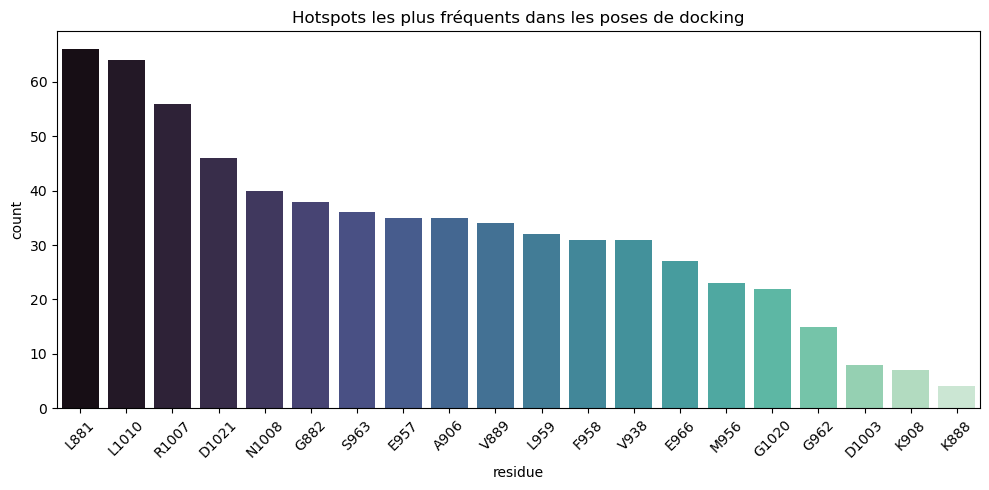

<Figure size 640x480 with 0 Axes>

In [19]:
process_all_docking_files()